In [ ]:
# ============================================================================
# Uni2TS Small - Google Colab T4 GPU
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p /content/drive/MyDrive/uni2ts_small_project

%cd /content/drive/MyDrive/uni2ts_small_project

!git clone https://github.com/SalesforceAIResearch/uni2ts
%cd uni2ts

%pip install torch transformers scikit-learn tqdm joblib gluonts lightning pytorch-lightning jaxtyping hydra-core

import torch
print("CUDA is available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(0))


Mounted at /content/drive
/content/drive/MyDrive/uni2ts_small_project
fatal: destination path 'uni2ts' already exists and is not an empty directory.
/content/drive/MyDrive/uni2ts_small_project/uni2ts
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.7 MB/s eta 0:00:00
 

In [ ]:
import sys
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import os
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from gluonts.dataset.common import ListDataset

sys.path.append("src")
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import random

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

MODEL_NAME = "Salesforce/moirai-1.1-R-small"
PRED_LEN = 1
PATCH_SIZE = "auto"

print(f"Model: {MODEL_NAME}")
print(f"Prediction length: {PRED_LEN}")

data_path = "/content/drive/MyDrive/ERP Data/all_window_datasets_unscaled.npz"
if os.path.exists(data_path):
    data = np.load(data_path, allow_pickle=True)
    print("Data loaded successfully!")
else:
    print(f"Data file not found: {data_path}")
    print("Please ensure all_window_datasets.npz is uploaded to Google Drive 'ERP Data' folder")

window_sizes = [5, 21, 252, 512]
results = {}

def get_batch_size(window_size):
    """
    Batch size configuration for T4 GPU (16GB).
    Uni2TS is a relatively large model, so use conservative batch sizes.
    """
    if window_size <= 5:
        return 4096
    elif window_size <= 21:
        return 4096
    elif window_size <= 252:
        return 512
    elif window_size <= 512:
        return 256
    else:
        return 4

print("T4 GPU optimized batch size configuration:")
for ws in window_sizes:
    batch_size = get_batch_size(ws)
    print(f"  Window {ws}: batch size = {batch_size}")


PyTorch version: 2.6.0+cu124
CUDA available: True
Using device: cuda
Model: Salesforce/moirai-1.1-R-small
Prediction length: 1
Data loaded successfully!
T4 GPU optimized batch size configuration:
  Window 5: batch size = 4096
  Window 21: batch size = 4096
  Window 252: batch size = 512
  Window 512: batch size = 256


In [ ]:
# ============================================================================
# Prediction and evaluation
# ============================================================================

def r2_zero(y_true, y_pred):
    """
    Compute R² (zero-based, baseline is 0)
    y_true: true values array (N,)
    y_pred: predicted values array (N,)
    """
    rss = np.sum((y_true - y_pred)**2)
    tss = np.sum(y_true**2)
    return 1 - rss / tss

def calc_directional_metrics(y_true, y_pred, permnos=None):
    """Compute directional accuracy metrics"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    if permnos is None:
        s_true = np.sign(y_true)
        s_pred = np.sign(y_pred)
        mask = s_true != 0
        s_true = s_true[mask]
        s_pred = s_pred[mask]
        overall_acc = np.mean(s_true == s_pred)
        up_mask = s_true > 0
        down_mask = s_true < 0
        up_acc = np.mean(s_true[up_mask] == s_pred[up_mask]) if np.any(up_mask) else 0
        down_acc = np.mean(s_true[down_mask] == s_pred[down_mask]) if np.any(down_mask) else 0
    else:
        df = pd.DataFrame({"permno": permnos, "yt": y_true, "yp": y_pred})
        overall_accs = []
        up_accs = []
        down_accs = []
        for _, g in df.groupby("permno"):
            s_true = np.sign(g["yt"].values)
            s_pred = np.sign(g["yp"].values)
            mask = s_true != 0
            s_true = s_true[mask]
            s_pred = s_pred[mask]
            if len(s_true) == 0:
                continue
            overall_accs.append(np.mean(s_true == s_pred))
            up_mask = s_true > 0
            down_mask = s_true < 0
            up_accs.append(np.mean(s_true[up_mask] == s_pred[up_mask]) if np.any(up_mask) else np.nan)
            down_accs.append(np.mean(s_true[down_mask] == s_pred[down_mask]) if np.any(down_mask) else np.nan)
        overall_acc = np.nanmean(overall_accs)
        up_acc = np.nanmean(up_accs)
        down_acc = np.nanmean(down_accs)
    return overall_acc, up_acc, down_acc

def calculate_metrics(y_true, y_pred, permnos=None, meta=None):
    """Compute evaluation metrics"""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    dir_acc, up_acc, down_acc = calc_directional_metrics(y_true, y_pred, permnos)
    r2 = r2_zero(y_true, y_pred)

    metrics = {
        "R2": r2,
        "MAE": mae,
        "MSE": mse,
        "Directional Accuracy": dir_acc,
        "Up_Directional_Acc": up_acc,
        "Down_Directional_Acc": down_acc
    }

    if meta is not None and "MKTCAP_PERCENTILE" in meta:
        top_mask = meta["MKTCAP_PERCENTILE"] >= 0.75
        bottom_mask = meta["MKTCAP_PERCENTILE"] <= 0.25

        if np.any(top_mask):
            yt_top = y_true[top_mask]
            yp_top = y_pred[top_mask]
            perm_top = permnos[top_mask] if permnos is not None else None
            r2_top = r2_zero(yt_top, yp_top)
            mae_top = mean_absolute_error(yt_top, yp_top)
            mse_top = mean_squared_error(yt_top, yp_top)
            dir_top, up_top, down_top = calc_directional_metrics(yt_top, yp_top, perm_top)
            metrics.update({
                "Top25_R2": r2_top,
                "Top25_MAE": mae_top,
                "Top25_MSE": mse_top,
                "Top25_Dir_Acc": dir_top,
                "Top25_Up_Acc": up_top,
                "Top25_Down_Acc": down_top
            })

        if np.any(bottom_mask):
            yt_bot = y_true[bottom_mask]
            yp_bot = y_pred[bottom_mask]
            perm_bot = permnos[bottom_mask] if permnos is not None else None
            r2_bot = r2_zero(yt_bot, yp_bot)
            mae_bot = mean_absolute_error(yt_bot, yp_bot)
            mse_bot = mean_squared_error(yt_bot, yp_bot)
            dir_bot, up_bot, down_bot = calc_directional_metrics(yt_bot, yp_bot, perm_bot)
            metrics.update({
                "Bottom25_R2": r2_bot,
                "Bottom25_MAE": mae_bot,
                "Bottom25_MSE": mse_bot,
                "Bottom25_Dir_Acc": dir_bot,
                "Bottom25_Up_Acc": up_bot,
                "Bottom25_Down_Acc": down_bot
            })

    return metrics


In [ ]:
def batch_predict_uni2ts(X_test, predictor, batch_size):
    """T4 GPU optimized batch inference function"""
    num_samples = len(X_test)
    all_predictions = np.zeros(num_samples)
    original_batch_size = batch_size

    print(f"Starting GPU optimized inference with batch size: {batch_size}")

    for i in tqdm(range(0, num_samples, batch_size), desc="GPU Batch Inference"):
        try:
            batch_end = min(i + batch_size, num_samples)
            batch_X = X_test[i:batch_end]

            # Prepare GluonTS data format
            batch_data = []
            for j in range(len(batch_X)):
                target = batch_X[j].flatten()

                data_entry = {
                    "target": target.tolist(),
                    "start": pd.Timestamp("2000-01-01"),
                    "item_id": f"item_{i+j}",
                }
                batch_data.append(data_entry)

            dataset = ListDataset(batch_data, freq="D")
            forecasts = list(predictor.predict(dataset))

            for k, forecast in enumerate(forecasts):
                # Use sample median
                all_predictions[i+k] = np.median(forecast.samples[:, 0])

            if i % (batch_size * 10) == 0 and torch.cuda.is_available():
                torch.cuda.empty_cache()

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                print(f"\nOOM detected. Reducing batch size from {batch_size} to {batch_size//2}")
                torch.cuda.empty_cache()
                batch_size = max(batch_size // 2, 1)

                # Retry current batch
                batch_end = min(i + batch_size, num_samples)
                batch_X = X_test[i:batch_end]

                batch_data = []

                for j in range(len(batch_X)):
                    target = batch_X[j].flatten()

                    data_entry = {
                      "target": target.tolist(),
                      "start": pd.Timestamp("2000-01-01"),
                      "item_id": f"item_{i+j}",
                    }
                    batch_data.append(data_entry)

                dataset = ListDataset(batch_data, freq="D")
                forecasts = list(predictor.predict(dataset))

                for k, forecast in enumerate(forecasts):
                    # Use sample median
                    all_predictions[i+k] = np.median(forecast.samples[:, 0])
            else:
                raise e

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"\nInference completed. Final batch size: {batch_size} (original: {original_batch_size})")
    return all_predictions

!mkdir -p /content/drive/MyDrive/uni2ts_small_project/uni2ts_results
!mkdir -p /content/drive/MyDrive/uni2ts_small_project/uni2ts_predictions

print("Starting T4 GPU optimized prediction...")
print(f"Data file contains keys: {list(data.keys())}")

for window_size in window_sizes:
    print(f"\n=== Processing Window Size: {window_size} ===")
    start_time = time.time()

    X_test = data[f"X_test_{window_size}"]
    y_test = data[f"y_test_{window_size}"]
    meta_test = pd.DataFrame(data[f"meta_test_{window_size}"].item())

    current_batch_size = get_batch_size(window_size)

    print(f"Test samples: {len(X_test):,}")
    print(f"Sequence length: {X_test.shape[1]}")
    print(f"Optimized batch size: {current_batch_size}")

    print("Initializing Uni2TS model...")
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(MODEL_NAME),
        prediction_length=PRED_LEN,
        context_length=window_size,
        patch_size=PATCH_SIZE,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

    try:
        model = model.to(device)
        print(f"Model loaded on: {device}")
    except Exception as e:
        print(f"Failed to load on {device}, using CPU: {str(e)}")
        model = model.to("cpu")
        device = "cpu"

    predictor = model.create_predictor(batch_size=current_batch_size)

    print("Starting batch inference...")
    all_predictions = batch_predict_uni2ts(X_test, predictor, current_batch_size)

    print("Calculating evaluation metrics...")
    permnos_test = meta_test["PERMNO"].values
    try:
        metrics = calculate_metrics(y_test, all_predictions, permnos_test, meta_test)
    except Exception as err:
        print(f"calculate_metrics failed: {err}")
        metrics = {}

    print("\n=== Directional Sanity Check ===")
    print("Pos ratio (y_test):", (y_test > 0).mean())
    print("Neg ratio (y_test):", (y_test < 0).mean())
    sign_pred = np.sign(all_predictions)
    print("Pred +1 ratio:", (sign_pred > 0).mean())
    print("Pred -1 ratio:", (sign_pred < 0).mean())

    from sklearn.metrics import confusion_matrix
    conf = confusion_matrix(np.sign(y_test), sign_pred, labels=[1, -1])
    print("      Pred+  Pred-")
    print("+1 |", conf[0])
    print("-1 |", conf[1])

    results[window_size] = {
        'predictions': all_predictions,
        'true_values': y_test,
        'metrics': metrics,
        'meta': meta_test
    }

    end_time = time.time()
    elapsed_time = end_time - start_time
    samples_per_second = len(X_test) / elapsed_time

    print(f"\nWindow {window_size} processing completed:")
    print(f"Total time: {elapsed_time:.2f} seconds")
    print(f"Processing speed: {samples_per_second:.0f} samples/second")

    print(f"\nMetrics for window {window_size}:")
    if metrics:
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    else:
        print("  (metrics is empty, skipped)")

    results_df = pd.DataFrame({
        'PERMNO': meta_test['PERMNO'],
        'y_true': y_test,
        'y_pred': all_predictions
    })
    results_df.to_csv(f'/content/drive/MyDrive/uni2ts_small_project/uni2ts_predictions/uni2ts_small_w{window_size}.csv', index=False)
    print(f"Predictions saved to uni2ts_small_w{window_size}.csv")

    try:
        del model, predictor
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception as e:
        print(f"Warning: Memory cleanup failed: {str(e)}")

print("\n=== All predictions completed! ===")


Starting T4 GPU optimized prediction...
Data file contains keys: ['X_train_5', 'y_train_5', 'meta_train_5', 'market_caps_train_5', 'X_test_5', 'y_test_5', 'meta_test_5', 'market_caps_test_5', 'X_train_21', 'y_train_21', 'meta_train_21', 'market_caps_train_21', 'X_test_21', 'y_test_21', 'meta_test_21', 'market_caps_test_21', 'X_train_252', 'y_train_252', 'meta_train_252', 'market_caps_train_252', 'X_test_252', 'y_test_252', 'meta_test_252', 'market_caps_test_252', 'X_train_512', 'y_train_512', 'meta_train_512', 'market_caps_train_512', 'X_test_512', 'y_test_512', 'meta_test_512', 'market_caps_test_512']

=== Processing Window Size: 5 ===
Test samples: 110,850
Sequence length: 5
Optimized batch size: 4096
Initializing Uni2TS model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/682 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/55.3M [00:00<?, ?B/s]

Model loaded on: cuda
Starting batch inference...
Starting GPU optimized inference with batch size: 4096


GPU Batch Inference: 100%|██████████| 28/28 [01:28<00:00,  3.15s/it]



Inference completed. Final batch size: 4096 (original: 4096)
Calculating evaluation metrics...

=== Directional Sanity Check ===
Pos ratio (y_test): 0.5225259359494813
Neg ratio (y_test): 0.47667117726657643
Pred +1 ratio: 0.5888949030221019
Pred -1 ratio: 0.41110509697789804
      Pred+  Pred-
+1 | [33701 24221]
-1 | [31525 21314]

Window 5 processing completed:
Total time: 101.13 seconds
Processing speed: 1096 samples/second

Metrics for window 5:
R2: -0.5887
MAE: 0.0149
MSE: 0.0004
Directional Accuracy: 0.4967
Up_Directional_Acc: 0.5813
Down_Directional_Acc: 0.4028
Top25_R2: -0.5902
Top25_MAE: 0.0128
Top25_MSE: 0.0003
Top25_Dir_Acc: 0.4868
Top25_Up_Acc: 0.5811
Top25_Down_Acc: 0.3751
Bottom25_R2: -0.5758
Bottom25_MAE: 0.0192
Bottom25_MSE: 0.0007
Bottom25_Dir_Acc: 0.4961
Bottom25_Up_Acc: 0.5606
Bottom25_Down_Acc: 0.4165
Predictions saved to uni2ts_small_w5.csv

=== Processing Window Size: 21 ===
Test samples: 110,850
Sequence length: 21
Optimized batch size: 4096
Initializing Uni2TS 

GPU Batch Inference: 100%|██████████| 28/28 [01:50<00:00,  3.94s/it]



Inference completed. Final batch size: 4096 (original: 4096)
Calculating evaluation metrics...

=== Directional Sanity Check ===
Pos ratio (y_test): 0.5225259359494813
Neg ratio (y_test): 0.47667117726657643
Pred +1 ratio: 0.5810915651781687
Pred -1 ratio: 0.4189084348218313
      Pred+  Pred-
+1 | [33327 24595]
-1 | [31037 21802]

Window 21 processing completed:
Total time: 113.30 seconds
Processing speed: 978 samples/second

Metrics for window 21:
R2: -0.2584
MAE: 0.0133
MSE: 0.0003
Directional Accuracy: 0.4977
Up_Directional_Acc: 0.5747
Down_Directional_Acc: 0.4118
Top25_R2: -0.2609
Top25_MAE: 0.0115
Top25_MSE: 0.0002
Top25_Dir_Acc: 0.4663
Top25_Up_Acc: 0.4947
Top25_Down_Acc: 0.3957
Bottom25_R2: -0.2530
Bottom25_MAE: 0.0173
Bottom25_MSE: 0.0006
Bottom25_Dir_Acc: 0.4968
Bottom25_Up_Acc: 0.5431
Bottom25_Down_Acc: 0.4377
Predictions saved to uni2ts_small_w21.csv

=== Processing Window Size: 252 ===
Test samples: 110,850
Sequence length: 252
Optimized batch size: 512
Initializing Uni2T

GPU Batch Inference: 100%|██████████| 217/217 [08:50<00:00,  2.44s/it]



Inference completed. Final batch size: 512 (original: 512)
Calculating evaluation metrics...

=== Directional Sanity Check ===
Pos ratio (y_test): 0.5225259359494813
Neg ratio (y_test): 0.47667117726657643
Pred +1 ratio: 0.5389354984212901
Pred -1 ratio: 0.46106450157871
      Pred+  Pred-
+1 | [30915 27007]
-1 | [28779 24060]

Window 252 processing completed:
Total time: 539.73 seconds
Processing speed: 205 samples/second

Metrics for window 252:
R2: -0.1170
MAE: 0.0126
MSE: 0.0003
Directional Accuracy: 0.4963
Up_Directional_Acc: 0.5326
Down_Directional_Acc: 0.4541
Top25_R2: -0.1190
Top25_MAE: 0.0108
Top25_MSE: 0.0002
Top25_Dir_Acc: 0.4503
Top25_Up_Acc: 0.5214
Top25_Down_Acc: 0.3884
Bottom25_R2: -0.1144
Bottom25_MAE: 0.0163
Bottom25_MSE: 0.0005
Bottom25_Dir_Acc: 0.4933
Bottom25_Up_Acc: 0.4814
Bottom25_Down_Acc: 0.4948
Predictions saved to uni2ts_small_w252.csv

=== Processing Window Size: 512 ===
Test samples: 110,850
Sequence length: 512
Optimized batch size: 256
Initializing Uni2TS

GPU Batch Inference: 100%|██████████| 434/434 [16:59<00:00,  2.35s/it]



Inference completed. Final batch size: 256 (original: 256)
Calculating evaluation metrics...

=== Directional Sanity Check ===
Pos ratio (y_test): 0.5225259359494813
Neg ratio (y_test): 0.47667117726657643
Pred +1 ratio: 0.5483355886332882
Pred -1 ratio: 0.45166441136671176
      Pred+  Pred-
+1 | [31430 26492]
-1 | [29308 23531]

Window 512 processing completed:
Total time: 1034.50 seconds
Processing speed: 107 samples/second

Metrics for window 512:
R2: -0.0993
MAE: 0.0125
MSE: 0.0003
Directional Accuracy: 0.4962
Up_Directional_Acc: 0.5414
Down_Directional_Acc: 0.4440
Top25_R2: -0.0989
Top25_MAE: 0.0107
Top25_MSE: 0.0002
Top25_Dir_Acc: 0.4854
Top25_Up_Acc: 0.5683
Top25_Down_Acc: 0.3893
Bottom25_R2: -0.0988
Bottom25_MAE: 0.0162
Bottom25_MSE: 0.0005
Bottom25_Dir_Acc: 0.4964
Bottom25_Up_Acc: 0.4846
Bottom25_Down_Acc: 0.4968
Predictions saved to uni2ts_small_w512.csv

=== All predictions completed! ===


Results saved to results.pkl
Metrics saved to uni2ts_small_metrics.csv

=== Metrics Summary ===
   Window      R2     MAE     MSE  Directional Accuracy  Up_Directional_Acc  \
0       5 -0.5887  0.0149  0.0004                0.4967              0.5813   
1      21 -0.2584  0.0133  0.0003                0.4977              0.5747   
2     252 -0.1170  0.0126  0.0003                0.4963              0.5326   
3     512 -0.0993  0.0125  0.0003                0.4962              0.5414   

   Down_Directional_Acc  Top25_R2  Top25_MAE  Top25_MSE  Top25_Dir_Acc  \
0                0.4028   -0.5902     0.0128     0.0003         0.4868   
1                0.4118   -0.2609     0.0115     0.0002         0.4663   
2                0.4541   -0.1190     0.0108     0.0002         0.4503   
3                0.4440   -0.0989     0.0107     0.0002         0.4854   

   Top25_Up_Acc  Top25_Down_Acc  Bottom25_R2  Bottom25_MAE  Bottom25_MSE  \
0        0.5811          0.3751      -0.5758        0.0192   

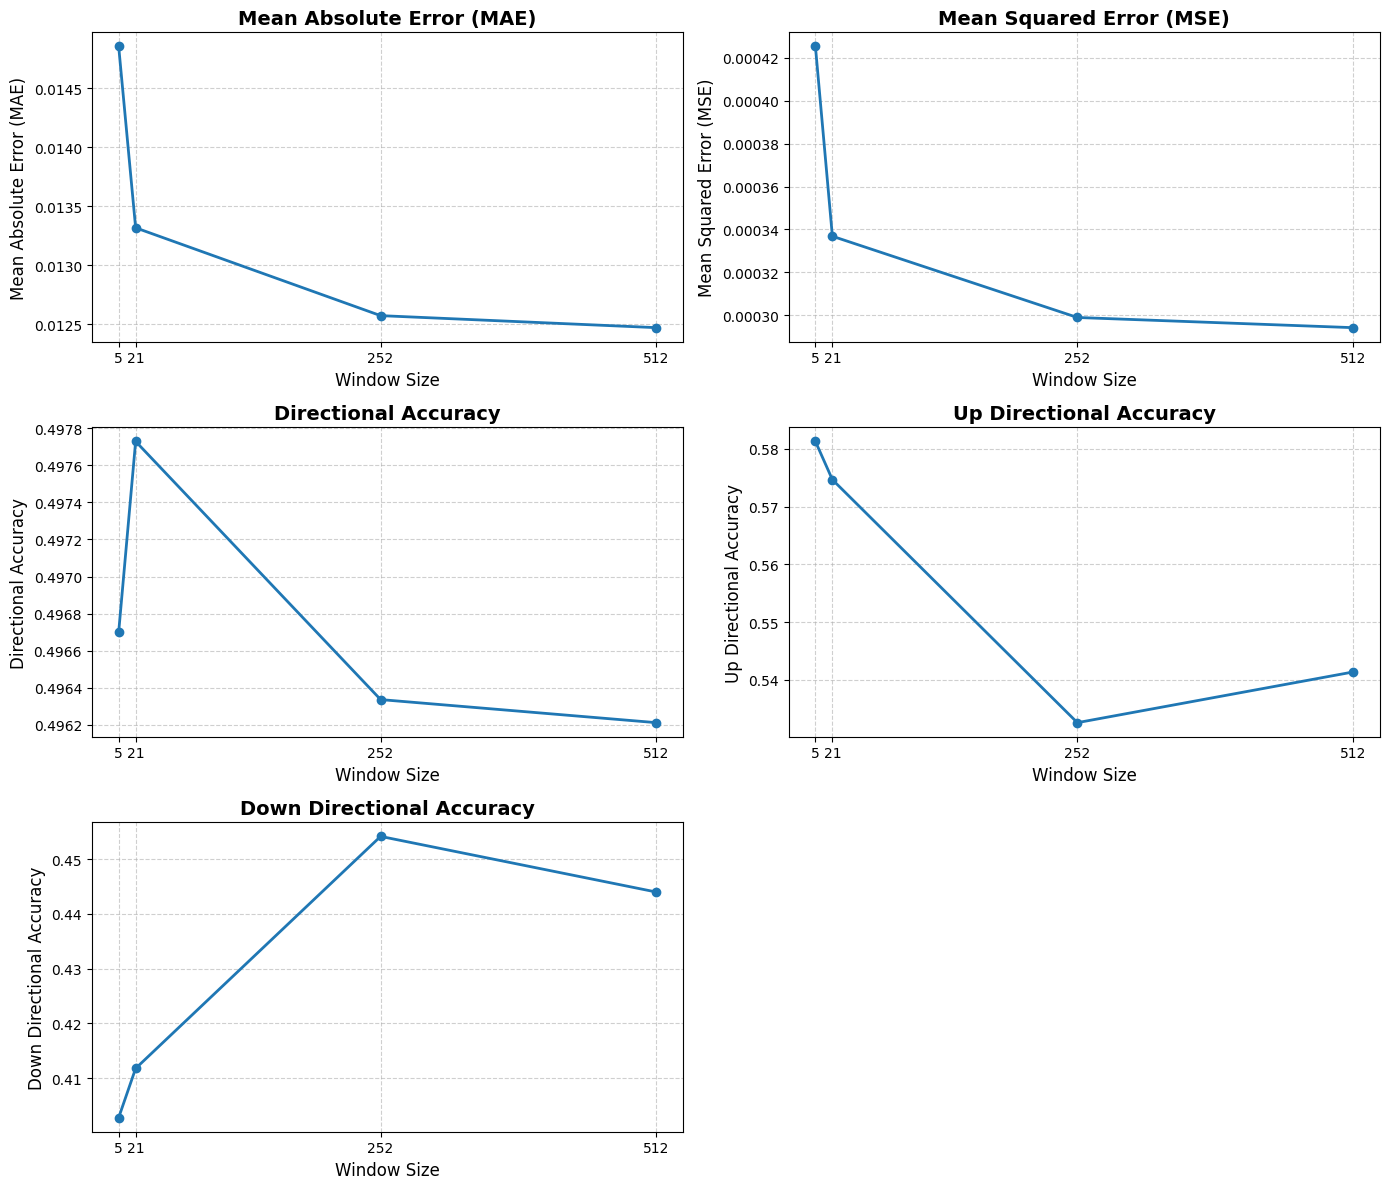


=== All results saved to Google Drive! ===
Files saved to: /content/drive/MyDrive/uni2ts_small_project/


In [ ]:
# ============================================================================
# Save results and generate visualizations
# ============================================================================

results_dict = {
    'window_sizes': window_sizes,
    'results': results,
    'model_name': 'Uni2TS-Small',
    'model_version': 'T4_GPU_Optimized',
    'model_params': {
        'device': device,
        'batch_sizes': {ws: get_batch_size(ws) for ws in window_sizes},
        'gpu_optimized': True
    }
}
joblib.dump(results_dict, "/content/drive/MyDrive/uni2ts_small_project/uni2ts_results/results.pkl")
print("Results saved to results.pkl")

# Only generate summary if all windows have valid metrics
valid_results = {ws: results[ws] for ws in window_sizes if results[ws]['metrics']}

if valid_results:
    metrics_df = pd.DataFrame([
        {**{"Window": window_size}, **valid_results[window_size]["metrics"]}
        for window_size in valid_results.keys()
    ])
    metrics_df.to_csv("/content/drive/MyDrive/uni2ts_small_project/uni2ts_results/uni2ts_small_metrics.csv", index=False)
    print("Metrics saved to uni2ts_small_metrics.csv")

    print("\n=== Metrics Summary ===")
    print(metrics_df.round(4))

    metrics_to_plot = ["R²", "MAE", "MSE", "Directional Accuracy", "Up_Directional_Acc", "Down_Directional_Acc"]
    metric_names = {
        "R²": "R²",
        "MAE": "Mean Absolute Error (MAE)",
        "MSE": "Mean Squared Error (MSE)",
        "Directional Accuracy": "Directional Accuracy",
        "Up_Directional_Acc": "Up Directional Accuracy",
        "Down_Directional_Acc": "Down Directional Accuracy"
    }

    available_metrics = [m for m in metrics_to_plot if m in metrics_df.columns]

    if available_metrics:
        fig, axs = plt.subplots(3, 2, figsize=(14, 12))
        axs = axs.flatten()

        for idx, metric in enumerate(available_metrics[:6]):
            ax = axs[idx]
            ax.plot(metrics_df["Window"], metrics_df[metric],
                    marker='o', linestyle='-', linewidth=2, color='#1f77b4')

            ax.set_title(metric_names[metric], fontsize=14, weight="bold")
            ax.set_xlabel("Window Size", fontsize=12)
            ax.set_ylabel(metric_names[metric], fontsize=12)
            ax.set_xticks(list(valid_results.keys()))
            ax.grid(True, linestyle='--', alpha=0.6)

        for idx in range(len(available_metrics), 6):
            axs[idx].set_visible(False)

        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/uni2ts_small_project/uni2ts_results/uni2ts_small_metrics.png", dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("No valid metrics found, skipping visualization")

print("\n=== All results saved to Google Drive! ===")
print("Files saved to: /content/drive/MyDrive/uni2ts_small_project/")
